In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [210]:
dog_bites_df = pd.read_csv('data/Dog_Bites_Data.csv')
akc_df = pd.read_csv('data/akc-data-latest.csv')

In [211]:
dog_bites_df.head()

,UniqueID,DateOfBite,Species,Breed,Age,Gender,SpayNeuter,Borough,ZipCode
0,1,January 01 2018,DOG,UNKNOWN,NaN,U,False,Brooklyn,11220
1,2,January 04 2018,DOG,UNKNOWN,NaN,U,False,Brooklyn,NaN
2,3,January 06 2018,DOG,Pit Bull,NaN,U,False,Brooklyn,11224
3,4,January 08 2018,DOG,Mixed/Other,4,M,False,Brooklyn,11231
4,5,January 09 2018,DOG,Pit Bull,NaN,U,False,Brooklyn,11224


In [212]:
dog_bites_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22663 entries, 0 to 22662
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   UniqueID    22663 non-null  int64 
 1   DateOfBite  22663 non-null  object
 2   Species     22663 non-null  object
 3   Breed       20445 non-null  object
 4   Age         11442 non-null  object
 5   Gender      22663 non-null  object
 6   SpayNeuter  22663 non-null  bool  
 7   Borough     22663 non-null  object
 8   ZipCode     16805 non-null  object
dtypes: bool(1), int64(1), object(7)
memory usage: 1.4+ MB


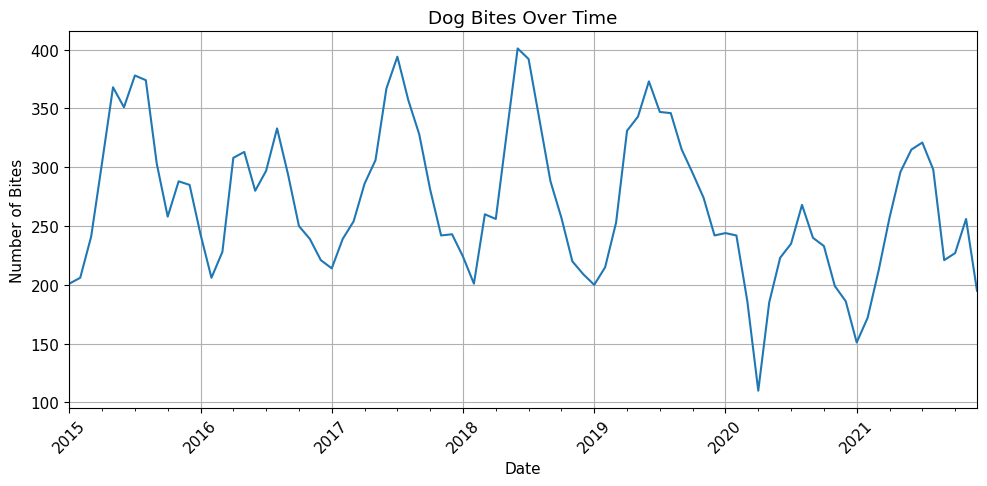

In [213]:
# Convert 'DateOfBite' to datetime format
dog_bites_df['DateOfBite'] = pd.to_datetime(dog_bites_df['DateOfBite'], errors='coerce')

bites_over_time = dog_bites_df.groupby(dog_bites_df['DateOfBite'].dt.to_period('M')).size()

# Line plot for dog bites over time
plt.figure(figsize=(10, 5))
bites_over_time.plot(kind='line')
plt.title('Dog Bites Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Bites')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [214]:
# Define a function to categorize dates into seasons
def get_season(date):
    if date.month in [12, 1, 2]:
        return 'Winter'
    elif date.month in [3, 4, 5]:
        return 'Spring'
    elif date.month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

# Apply the function to create a 'Season' column
dog_bites_df['Season'] = dog_bites_df['DateOfBite'].apply(get_season)

In [215]:
dog_bites_df = dog_bites_df.drop('DateOfBite', axis=1)

In [216]:
# Import fuzzywuzzy library
from fuzzywuzzy import process

# Fill NaN values in the 'Breed' column with 'unknown' and convert to lowercase
dog_bites_df['Breed'] = dog_bites_df['Breed'].str.lower().fillna('unknown')

# Retry the process of creating a breed mapping dictionary
dog_bites_breeds = dog_bites_df['Breed'].str.lower().unique()  # Apply strip and lower element-wise
akc_breeds = akc_df['Unnamed: 0'].str.lower().unique()

# Function to perform fuzzy matching
def get_closest_match(breed, akc_breeds):
    match, score = process.extractOne(breed, akc_breeds)
    return match if score > 80 else None  # If the similarity score is high, return the AKC breed; otherwise return None

# Refined function to handle breed names and attempt fuzzy/substring matching
def match_breed(breed, akc_breeds):
    # Step 1: Apply fuzzy matching for entire breed name
    closest_match = get_closest_match(breed, akc_breeds)
    if closest_match:
        return closest_match
    
    # Step 2: Try substring matching
    for akc_breed in akc_breeds:
        if breed in akc_breed or akc_breed in breed:
            return akc_breed
    
    # Step 3: If no match is found, return None
    return None

# Create a mapping dictionary to standardize dog breeds based on the AKC breed list using fuzzy matching and substring matching
breed_mapping_dict = {}

# Go through all breeds in Dog Bites dataset
for breed in dog_bites_breeds:
    # Handle 'Mixed' and 'Crossbreed' cases
    if 'mix' in breed or 'crossbreed' in breed:
        breed_mapping_dict[breed] = 'mixed'
    
    # Try to match breed via fuzzy and substring matching
    else:
        matched_breed = match_breed(breed, akc_breeds)
        
        if matched_breed:  # If a match is found (fuzzy or substring)
            breed_mapping_dict[breed] = matched_breed
        else:
            # If no match is found, categorize as 'unknown'
            breed_mapping_dict[breed] = 'unknown'

# Step 1: Create a new column 'original_breed' to preserve the original breed names
dog_bites_df['original_breed'] = dog_bites_df['Breed']

# Step 2: Apply the breed_mapping_dict to clean the 'Breed' column (which will now be the standardized breed)
dog_bites_df['Breed'] = dog_bites_df['original_breed'].map(breed_mapping_dict)

# Replace any NaN values that resulted from mapping with 'unknown'
dog_bites_df['Breed'] = dog_bites_df['Breed'].fillna('unknown')

# Display the cleaned dataframe with both original and standardized breed columns
dog_bites_df.head()


,UniqueID,Species,Breed,Age,Gender,SpayNeuter,Borough,ZipCode,Season,original_breed
0,1,DOG,unknown,NaN,U,False,Brooklyn,11220,Winter,unknown
1,2,DOG,unknown,NaN,U,False,Brooklyn,NaN,Winter,unknown
2,3,DOG,bull terrier,NaN,U,False,Brooklyn,11224,Winter,pit bull
3,4,DOG,mixed,4,M,False,Brooklyn,11231,Winter,mixed/other
4,5,DOG,bull terrier,NaN,U,False,Brooklyn,11224,Winter,pit bull


In [217]:
akc_df.head()

,Unnamed: 0,description,temperament,popularity,min_height,max_height,min_weight,max_weight,min_expectancy,max_expectancy,...,grooming_frequency_value,grooming_frequency_category,shedding_value,shedding_category,energy_level_value,energy_level_category,trainability_value,trainability_category,demeanor_value,demeanor_category
0,Affenpinscher,The Affen’s apish look has been described many...,"Confident, Famously Funny, Fearless",148,22.86,29.21,3.175147,4.535924,12.0,15.0,...,0.6,2-3 Times a Week Brushing,0.6,Seasonal,0.6,Regular Exercise,0.8,Easy Training,1.0,Outgoing
1,Afghan Hound,"The Afghan Hound is an ancient breed, his whol...","Dignified, Profoundly Loyal, Aristocratic",113,63.50,68.58,22.679619,27.215542,12.0,15.0,...,0.8,Daily Brushing,0.2,Infrequent,0.8,Energetic,0.2,May be Stubborn,0.2,Aloof/Wary
2,Airedale Terrier,The Airedale Terrier is the largest of all ter...,"Friendly, Clever, Courageous",60,58.42,58.42,22.679619,31.751466,11.0,14.0,...,0.6,2-3 Times a Week Brushing,0.4,Occasional,0.6,Regular Exercise,1.0,Eager to Please,0.8,Friendly
3,Akita,"Akitas are burly, heavy-boned spitz-type dogs ...","Courageous, Dignified, Profoundly Loyal",47,60.96,71.12,31.751466,58.967008,10.0,13.0,...,0.8,Daily Brushing,0.6,Seasonal,0.8,Energetic,1.0,Eager to Please,0.6,Alert/Responsive
4,Alaskan Malamute,The Alaskan Malamute stands 23 to 25 inches at...,"Affectionate, Loyal, Playful",58,58.42,63.50,34.019428,38.555351,10.0,14.0,...,0.6,2-3 Times a Week Brushing,0.6,Seasonal,0.8,Energetic,0.4,Independent,0.8,Friendly


In [218]:
# Rename 'Unnamed: 0' in akc_df to 'Breed' to match the column in dog_bites_df
akc_df.rename(columns={'Unnamed: 0': 'Breed'}, inplace=True)

# Convert 'Breed' column in akc_df to lowercase
akc_df['Breed'] = akc_df['Breed'].str.lower()

# Create dictionaries from akc_df to map Breed to trainability_value and group
trainability_dict = akc_df.set_index('Breed')['trainability_value'].to_dict()
group_dict = akc_df.set_index('Breed')['group'].to_dict()

# Define a function to set 'mixed' and 'unknown' to NaN, and map other breeds using the dictionaries
def get_trainability_and_group(breed):
    if breed in ['mixed', 'unknown']:
        return np.nan, np.nan  # Return NaN for both trainability and group
    else:
        # Use the dictionaries to get trainability_value and group, or return NaN if the breed is not found
        trainability_value = trainability_dict.get(breed, np.nan)
        group = group_dict.get(breed, np.nan)
        return trainability_value, group

# Apply the function to populate both 'trainability_value' and 'group' columns in dog_bites_df
dog_bites_df[['trainability_value', 'group']] = dog_bites_df['Breed'].apply(
    lambda breed: pd.Series(get_trainability_and_group(breed))
)

In [219]:
# Function to adjust trainability_value randomly within -0.2 to 0.2, ensuring the result stays between 0 and 1 and is rounded to two decimal places
def adjust_trainability(value):
    if pd.isna(value):
        return np.nan  # If the value is NaN, return NaN
    adjustment = np.random.uniform(-0.2, 0.2)  # Random adjustment between -0.2 and 0.2
    new_value = value + adjustment
    new_value = np.clip(new_value, 0, 1)  # Ensures value stays between 0 and 1
    return round(new_value, 2)  # Round to two decimal places

In [222]:
# Apply the function to adjust 'trainability_value' for each row
dog_bites_df['trainability_value'] = dog_bites_df['trainability_value'].apply(adjust_trainability)

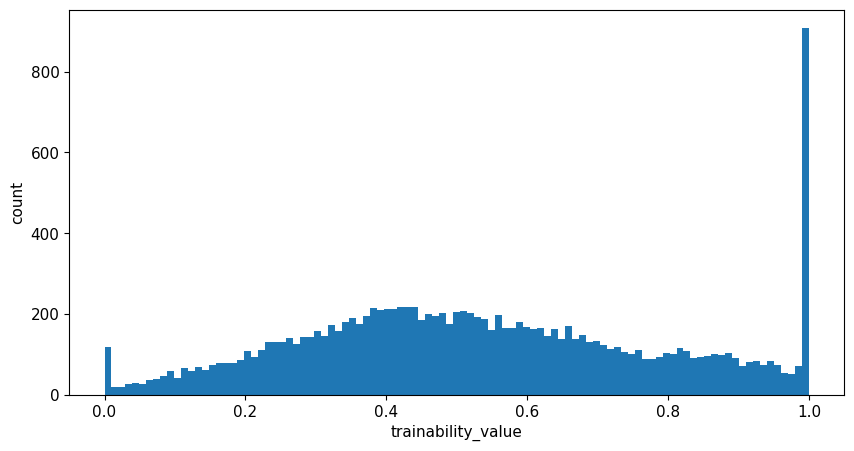

In [223]:
plt.figure(figsize=(10, 5))

dog_bites_df['trainability_value'].plot.hist(bins = dog_bites_df['trainability_value'].nunique())   # bins = int(np.sqrt(df.shape[0])) 
                        # bins = df['age'].nunique()
plt.xlabel('trainability_value')
plt.ylabel('count')
plt.show()

In [244]:
def adjust_trainability_with_conditions(row):
    adjustment = 0  # 默认不调整
    if row['Gender'] == 'F':
        adjustment += np.random.uniform(-0.05, 0.15)
    # if row['SpayNeuter'] == 'False':
    #     adjustment += np.random.uniform(0.1, 0.2)
    if row['Borough'] != 'Brooklyn':
        adjustment += np.random.uniform(-0.15, 0.1)
    if row['Season'] == 'Summer':
        adjustment += np.random.uniform(-0.1, -0.05)

    # 调整 trainability_value，并确保结果在 [0, 1] 范围内
    new_value = row['trainability_value'] + adjustment
    new_value = np.clip(new_value, 0, 1)  # 保证在 0 到 1 之间
    return round(new_value, 2)

# 应用调整函数到每一行
dog_bites_df['trainability_value'] = dog_bites_df.apply(adjust_trainability_with_conditions, axis=1)

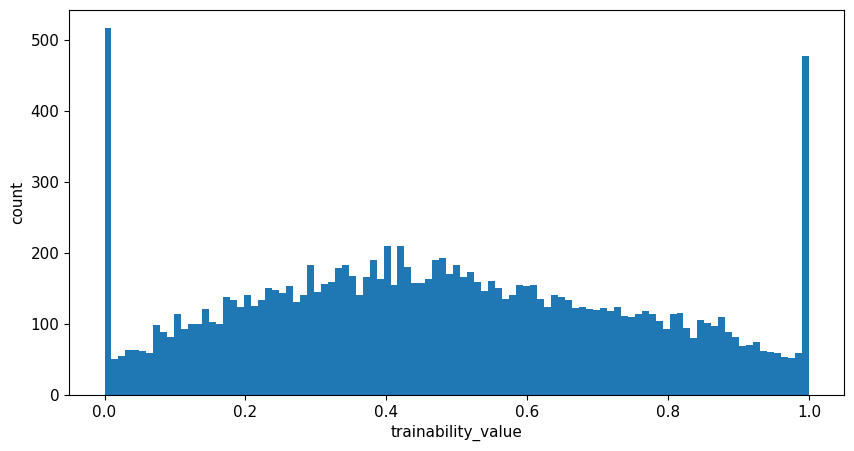

In [245]:
plt.figure(figsize=(10, 5))

dog_bites_df['trainability_value'].plot.hist(bins = dog_bites_df['trainability_value'].nunique())   # bins = int(np.sqrt(df.shape[0])) 
                        # bins = df['age'].nunique()
plt.xlabel('trainability_value')
plt.ylabel('count')
plt.show()

In [246]:
dog_bites_df

,UniqueID,Species,Breed,Age,Gender,SpayNeuter,Borough,ZipCode,Season,original_breed,trainability_value,group,Age_Range
0,1,DOG,unknown,NaN,U,False,Brooklyn,11220,Winter,unknown,NaN,NaN,None
1,2,DOG,unknown,NaN,U,False,Brooklyn,NaN,Winter,unknown,NaN,NaN,None
2,3,DOG,bull terrier,NaN,U,False,Brooklyn,11224,Winter,pit bull,0.38,Terrier Group,None
3,4,DOG,mixed,4,M,False,Brooklyn,11231,Winter,mixed/other,NaN,NaN,Adult (3-7 Years)
4,5,DOG,bull terrier,NaN,U,False,Brooklyn,11224,Winter,pit bull,0.69,Terrier Group,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22658,10276,DOG,mixed,7,M,True,Staten Island,10303,Winter,chiweenie mix,NaN,NaN,Adult (3-7 Years)
22659,10277,DOG,unknown,5,F,True,Staten Island,10303,Winter,dunker,NaN,NaN,Adult (3-7 Years)
22660,10278,DOG,miniature schnauzer,10M,M,True,Staten Island,10312,Winter,"schnauzer, miniature",0.85,Terrier Group,Puppy/Young (0-2 Years)
22661,10279,DOG,mixed,NaN,F,False,Staten Island,10308,Winter,mixed/other,NaN,NaN,None


In [247]:
dog_bites_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22663 entries, 0 to 22662
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   UniqueID            22663 non-null  int64  
 1   Species             22663 non-null  object 
 2   Breed               22663 non-null  object 
 3   Age                 11442 non-null  object 
 4   Gender              22663 non-null  object 
 5   SpayNeuter          22663 non-null  bool   
 6   Borough             22663 non-null  object 
 7   ZipCode             16805 non-null  object 
 8   Season              22663 non-null  object 
 9   original_breed      22663 non-null  object 
 10  trainability_value  13299 non-null  float64
 11  group               13476 non-null  object 
 12  Age_Range           11441 non-null  object 
dtypes: bool(1), float64(1), int64(1), object(10)
memory usage: 2.1+ MB


In [327]:
dog_bites_df = dog_bites_df.dropna(subset=['trainability_value'])
file_path = "data/dog_bites_df.csv"
dog_bites_df.to_csv(file_path, index=False)

In [329]:
dog_bites_df = dog_bites_df.drop(columns=['Age'])
dog_bites_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13299 entries, 2 to 22662
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   UniqueID            13299 non-null  int64  
 1   Species             13299 non-null  object 
 2   Breed               13299 non-null  object 
 3   Gender              13299 non-null  object 
 4   SpayNeuter          13299 non-null  bool   
 5   Borough             13299 non-null  object 
 6   ZipCode             10355 non-null  object 
 7   Season              13299 non-null  object 
 8   original_breed      13299 non-null  object 
 9   trainability_value  13299 non-null  float64
 10  group               13299 non-null  object 
 11  Age_Range           7261 non-null   object 
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 1.2+ MB


In [248]:
df = dog_bites_df.dropna(subset=['trainability_value'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13299 entries, 2 to 22662
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   UniqueID            13299 non-null  int64  
 1   Species             13299 non-null  object 
 2   Breed               13299 non-null  object 
 3   Age                 7262 non-null   object 
 4   Gender              13299 non-null  object 
 5   SpayNeuter          13299 non-null  bool   
 6   Borough             13299 non-null  object 
 7   ZipCode             10355 non-null  object 
 8   Season              13299 non-null  object 
 9   original_breed      13299 non-null  object 
 10  trainability_value  13299 non-null  float64
 11  group               13299 non-null  object 
 12  Age_Range           7261 non-null   object 
dtypes: bool(1), float64(1), int64(1), object(10)
memory usage: 1.3+ MB


In [249]:
# Show the number of each distinct category of a specific feature
age_counts = dog_bites_df['Age'].value_counts().head(40)

# Print the result
print(age_counts)

2          1624
3          1504
1          1365
4          1178
5          1040
6           795
7           655
8           569
9           375
10          361
11          242
12          188
13          140
8M           83
10M          80
14           75
11M          70
3M           66
4M           65
9M           55
15           51
6M           50
5M           50
2Y           47
7M           45
2M           34
3Y           33
1Y           27
4Y           26
16           22
3 YRS        20
5Y           20
2 YRS        20
6Y           17
8Y           14
4 YRS        13
10 MTHS      13
10Y          11
9 MTHS       11
4 MTHS       10
Name: Age, dtype: int64


In [250]:
# 定义将年龄转换为月龄的函数
def convert_age_to_range(age):
    if pd.isnull(age):  # 缺失值直接返回 None
        return None
    try:
        age = str(age).strip().upper()
        if "Y" in age:  # 如果包含年
            years = int(''.join(filter(str.isdigit, age.split("Y")[0])))  # 提取数字部分
            if years <= 2:
                return "Puppy/Young (0-2 Years)"
            elif 3 <= years <= 7:
                return "Adult (3-7 Years)"
            else:
                return "Senior (8+ Years)"
        elif "M" in age:  # 如果包含月
            months = int(''.join(filter(str.isdigit, age.split("M")[0])))  # 提取数字部分
            if months <= 24:
                return "Puppy/Young (0-2 Years)"
            elif 25 <= months <= 84:
                return "Adult (3-7 Years)"
            else:
                return "Senior (8+ Years)"
        else:  # 如果既不包含年也不包含月，按默认逻辑处理为年
            years = int(''.join(filter(str.isdigit, age)))
            if years <= 2:
                return "Puppy/Young (0-2 Years)"
            elif 3 <= years <= 7:
                return "Adult (3-7 Years)"
            else:
                return "Senior (8+ Years)"
    except Exception as e:
        print(f"Error processing age: {age} -> {e}")
        return None

# 应用转换函数
dog_bites_df['Age_Range'] = dog_bites_df['Age'].apply(convert_age_to_range)

# Show the number of each distinct category of a specific feature
age_counts = dog_bites_df['Age_Range'].value_counts()

# Print the result
print(age_counts)

Error processing age: Y RS -> invalid literal for int() with base 10: ''
Adult (3-7 Years)          5352
Puppy/Young (0-2 Years)    3864
Senior (8+ Years)          2225
Name: Age_Range, dtype: int64


In [251]:
dog_bites_df

,UniqueID,Species,Breed,Age,Gender,SpayNeuter,Borough,ZipCode,Season,original_breed,trainability_value,group,Age_Range
0,1,DOG,unknown,NaN,U,False,Brooklyn,11220,Winter,unknown,NaN,NaN,None
1,2,DOG,unknown,NaN,U,False,Brooklyn,NaN,Winter,unknown,NaN,NaN,None
2,3,DOG,bull terrier,NaN,U,False,Brooklyn,11224,Winter,pit bull,0.38,Terrier Group,None
3,4,DOG,mixed,4,M,False,Brooklyn,11231,Winter,mixed/other,NaN,NaN,Adult (3-7 Years)
4,5,DOG,bull terrier,NaN,U,False,Brooklyn,11224,Winter,pit bull,0.69,Terrier Group,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22658,10276,DOG,mixed,7,M,True,Staten Island,10303,Winter,chiweenie mix,NaN,NaN,Adult (3-7 Years)
22659,10277,DOG,unknown,5,F,True,Staten Island,10303,Winter,dunker,NaN,NaN,Adult (3-7 Years)
22660,10278,DOG,miniature schnauzer,10M,M,True,Staten Island,10312,Winter,"schnauzer, miniature",0.85,Terrier Group,Puppy/Young (0-2 Years)
22661,10279,DOG,mixed,NaN,F,False,Staten Island,10308,Winter,mixed/other,NaN,NaN,None


In [252]:
dog_bites_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22663 entries, 0 to 22662
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   UniqueID            22663 non-null  int64  
 1   Species             22663 non-null  object 
 2   Breed               22663 non-null  object 
 3   Age                 11442 non-null  object 
 4   Gender              22663 non-null  object 
 5   SpayNeuter          22663 non-null  bool   
 6   Borough             22663 non-null  object 
 7   ZipCode             16805 non-null  object 
 8   Season              22663 non-null  object 
 9   original_breed      22663 non-null  object 
 10  trainability_value  13299 non-null  float64
 11  group               13476 non-null  object 
 12  Age_Range           11441 non-null  object 
dtypes: bool(1), float64(1), int64(1), object(10)
memory usage: 2.1+ MB


In [253]:
df = dog_bites_df.dropna(subset=['trainability_value'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13299 entries, 2 to 22662
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   UniqueID            13299 non-null  int64  
 1   Species             13299 non-null  object 
 2   Breed               13299 non-null  object 
 3   Age                 7262 non-null   object 
 4   Gender              13299 non-null  object 
 5   SpayNeuter          13299 non-null  bool   
 6   Borough             13299 non-null  object 
 7   ZipCode             10355 non-null  object 
 8   Season              13299 non-null  object 
 9   original_breed      13299 non-null  object 
 10  trainability_value  13299 non-null  float64
 11  group               13299 non-null  object 
 12  Age_Range           7261 non-null   object 
dtypes: bool(1), float64(1), int64(1), object(10)
memory usage: 1.3+ MB


In [254]:
df = df.drop(columns=['UniqueID', 'Species', 'original_breed', 'ZipCode'])
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 13299 entries, 2 to 22662
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Breed               13299 non-null  object 
 1   Age                 7262 non-null   object 
 2   Gender              13299 non-null  object 
 3   SpayNeuter          13299 non-null  bool   
 4   Borough             13299 non-null  object 
 5   Season              13299 non-null  object 
 6   trainability_value  13299 non-null  float64
 7   group               13299 non-null  object 
 8   Age_Range           7261 non-null   object 
dtypes: bool(1), float64(1), object(7)
memory usage: 948.1+ KB


In [255]:
df['Age_Range'] = df['Age_Range'].astype(str)

In [256]:
df = df.drop(columns=['Age', 'group'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13299 entries, 2 to 22662
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Breed               13299 non-null  object 
 1   Gender              13299 non-null  object 
 2   SpayNeuter          13299 non-null  bool   
 3   Borough             13299 non-null  object 
 4   Season              13299 non-null  object 
 5   trainability_value  13299 non-null  float64
 6   Age_Range           13299 non-null  object 
dtypes: bool(1), float64(1), object(5)
memory usage: 740.3+ KB


In [257]:
# preprocess with pipeline and columntransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

random_state = 42

# Define the feature and target variable
X = df.drop(columns=['trainability_value'])  # features
y = df['trainability_value']  # target

cat_ftrs = ['Breed','Gender','Borough','Season', 'SpayNeuter']
ordinal_ftrs = ['Age_Range']
ordinal_cats = [['Puppy/Young (0-2 Years)', 'Adult (3-7 Years)', 'Senior (8+ Years)', 'None']]

# one-hot encoder
# We need to replace the NaN with a string first!
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # 填充缺失值为出现频率最高的值
    ('onehot', OneHotEncoder(sparse_output=False,handle_unknown='ignore'))])

# ordinal encoder
# We need to replace the NaN with a string first!
ordinal_transformer = Pipeline(steps=[
    ('imputer2', SimpleImputer(strategy='constant',fill_value='None')),
    ('ordinal', OrdinalEncoder(categories = ordinal_cats))])

# collect the transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, cat_ftrs),
        ('ord', ordinal_transformer, ordinal_ftrs)])

In [264]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ParameterGrid

models = {
    "LinearRegression": LinearRegression,
    "Ridge": Ridge,
    "Lasso": Lasso,
    "RandomForest": RandomForestRegressor,
    "XGBoost": XGBRegressor,
    "SVR": SVR,
}

param_grids = {
    "Ridge": {
        'alpha': [1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2],  # Regularization strength
    },
    "Lasso": {
        'alpha': [1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2],  # Regularization strength
    }, 
    "LinearRegression": {
    }, 
    "RandomForest": {
        'max_depth': [1, 3, 10, 30, 100],
        'max_features': [0.5, 0.75, 1.0],
    },
    "XGBoost": {
        'learning_rate': [0.03],
        'n_estimators': [100, 300],
        'reg_alpha': [0e0, 1e-3, 1e-2, 1e-1, 1e0, 1e1],
        'reg_lambda': [0e0, 1e-2, 1e-1, 1e0, 1e1, 1e2],
        'max_depth' : [1,10,100]
    },
    "SVR": {
        'C': [1e-1, 1e0, 1e1, 1e2],
        'gamma': [1e-3, 1e-1, 1e1, 1e3, 1e5],
    },
}

nr_states = 3

# Initialize result storage
test_scores = {model_name: [] for model_name in models.keys()}
train_scores = {model_name: [] for model_name in models.keys()}

for i in range(nr_states):
    print(f"\nRandom State {i + 1}:")

    # Split dataset into train, validation, and test sets
    X_train, X_other, y_train, y_other = train_test_split(X, y, train_size=0.6, random_state=42*i)
    X_val, X_test, y_val, y_test = train_test_split(X_other, y_other, train_size=0.5, random_state=42*i)

    for model_name, model_class in models.items():
        print(f"\nRunning model: {model_name}")

        param_grid = param_grids[model_name]
        param_list = list(ParameterGrid(param_grid))

        train_score = np.zeros(len(param_list))
        val_score = np.zeros(len(param_list))
        models_list = []

        # Iterate through hyperparameter configurations
        for p in range(len(param_list)):
            params = param_list[p]
            print("   ", params)
            model = model_class(**params, random_state=42*i) if 'random_state' in model_class().get_params() else model_class(**params)
            pipe = make_pipeline(preprocessor, model)
            pipe.fit(X_train, y_train)
            models_list.append(pipe)

            # Calculate train and validation scores
            y_train_pred = pipe.predict(X_train)
            train_score[p] = mean_squared_error(y_train, y_train_pred)

            y_val_pred = pipe.predict(X_val)
            val_score[p] = mean_squared_error(y_val, y_val_pred)
        
            print("   ", f"Train MSE: {train_score[p]:.8f} | Validation MSE: {val_score[p]:.8f}")

            
        # Find the best parameters based on validation score
        best_index = np.argmin(val_score)
        best_params = param_list[best_index]
        
        print('Best model parameters:', best_params)
        print('Corresponding validation MSE:', val_score[best_index])

        # Save the best model and calculate test score
        best_model = models_list[best_index]
        y_test_pred = best_model.predict(X_test)
        test_score = mean_squared_error(y_test, y_test_pred)
        test_scores[model_name].append(test_score)
        print('Test score:', test_score)

# Aggregate test scores to compute mean and standard deviation for error bars
test_score_means = {model_name: np.mean(scores) for model_name, scores in test_scores.items()}
test_score_stds = {model_name: np.std(scores) for model_name, scores in test_scores.items()}


Random State 1:

Running model: LinearRegression
    {}
    Train MSE: 0.02865685 | Validation MSE: 96995991093421024.00000000
Best model parameters: {}
Corresponding validation MSE: 9.699599109342102e+16
Test score: 8.729639198521022e+16

Running model: Ridge
    {'alpha': 0.001}
    Train MSE: 0.02861821 | Validation MSE: 0.02950558
    {'alpha': 0.01}
    Train MSE: 0.02861825 | Validation MSE: 0.02950157
    {'alpha': 0.1}
    Train MSE: 0.02862173 | Validation MSE: 0.02946863
    {'alpha': 1.0}
    Train MSE: 0.02876096 | Validation MSE: 0.02942675
    {'alpha': 10.0}
    Train MSE: 0.03012376 | Validation MSE: 0.03054752
    {'alpha': 100.0}
    Train MSE: 0.03643059 | Validation MSE: 0.03738998
Best model parameters: {'alpha': 1.0}
Corresponding validation MSE: 0.029426745852566157
Test score: 0.02873609577962834

Running model: Lasso
    {'alpha': 0.001}
    Train MSE: 0.03590161 | Validation MSE: 0.03668449
    {'alpha': 0.01}
    Train MSE: 0.05467132 | Validation MSE: 0.056

In [334]:
best_model[]

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Breed', 'Gender', 'Borough',
                                                   'Season', 'SpayNeuter']),
                                                 ('ord',
                                                  Pipeline(steps=[('imputer2',
                                                                   SimpleImputer(fill_value='None',
                                                                                 strategy='constant')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(categories=[['Puppy/Young '
                                                                                               '(0-2 '
                                                                                               'Years)',
                                                                                               'Adult '
                                                                                               '(3-7 '
                                                                                               'Years)',
                                                                                               'Senior '
                                                                                               '(8+ '
                                                                                               'Years)',
                                                                                               'None']]))]),
                                                  ['Age_Range'])])),
                ('svr', SVR(C=100.0, gamma=0.001))])

# Best Hyperparameter Selection and Model Performances

| **Model**            | **Best Hyperparameters**                                                                                  | **Train MSE** | **Validation MSE** | **Test MSE**   |
|-----------------------|----------------------------------------------------------------------------------------------------------|---------------|---------------------|----------------|
| **Linear Regression** | Not Applicable (Unstable performance)                                                                   | 0.02865       | 9.6995991e+16      | Not Applicable |
| **Ridge Regression**  | `alpha = 1.0`                                                                                           | 0.0292338     | 0.02942675         | 0.0287361      |
| **Lasso Regression**  | `alpha = 0.001`                                                                                         | 0.03582378    | 0.03668449         | 0.03652699     |
| **Random Forest**     | `max_depth = 30, max_features = 0.5`                                                                    | 0.03332045    | 0.03499077         | 0.03442183     |
| **XGBoost**           | `max_depth = 10, n_estimators = 300, reg_alpha = 0.001, reg_lambda = 100.0`      | 0.02925104    | 0.03048678         | 0.02984161     |
| **SVR**               | `C = 100.0, gamma = 0.001`                                                                              | 0.02883048    | 0.02957849         | 0.02900062     |

---

## Final Recommendation

Based on the validation and test MSE, the top-performing models are:

1. **XGBoost**:
   - **Validation MSE**: `0.03048678`
   - **Test MSE**: `0.02984161`

2. **Ridge Regression**:
   - **Validation MSE**: `0.02942675`
   - **Test MSE**: `0.0287361`

3. **SVR**:
   - **Validation MSE**: `0.02957849`
   - **Test MSE**: `0.02900062`

### Recommended Model and Hyperparameters:
- **XGBoost** is recommended for its strong performance and flexibility.
- **Best Hyperparameters for XGBoost**:
  ```json
  {
    "learning_rate": 0.03,
    "max_depth": 10,
    "n_estimators": 2500,
    "reg_alpha": 0.001,
    "reg_lambda": 100.0
  }


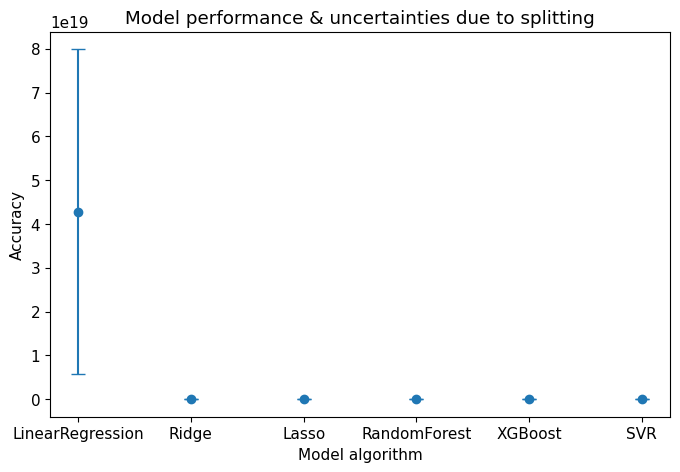

In [265]:
# Plot the results
model_names = list(test_scores.keys())
means = [test_score_means[name] for name in model_names]
stds = [test_score_stds[name] for name in model_names]

plt.figure(figsize=(8, 5))
plt.errorbar(model_names, means, yerr=stds, fmt='o', capsize=5)
plt.title("Model performance & uncertainties due to splitting")
plt.xlabel("Model algorithm")
plt.ylabel("Accuracy")
plt.show()

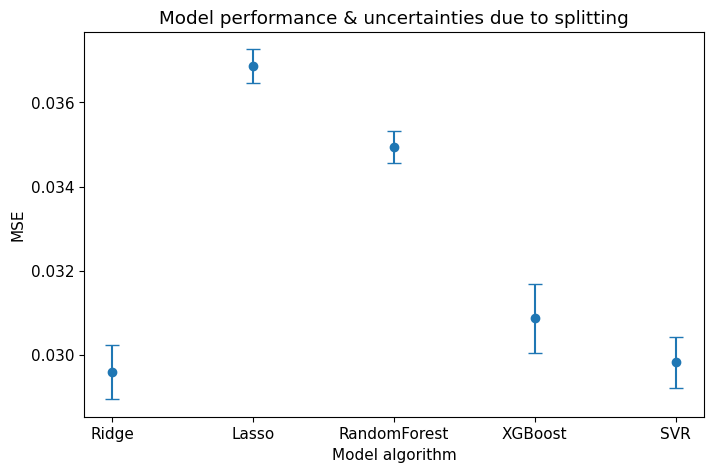

In [332]:
filtered_model_names = [name for name in model_names if name != "LinearRegression"]
filtered_means = [test_score_means[name] for name in filtered_model_names]
filtered_stds = [test_score_stds[name] for name in filtered_model_names]

# Plot the results
plt.figure(figsize=(8, 5))
plt.errorbar(filtered_model_names, filtered_means, yerr=filtered_stds, fmt='o', capsize=5)
plt.title("Model performance & uncertainties due to splitting")
plt.xlabel("Model algorithm")
plt.ylabel("MSE")
plt.show()

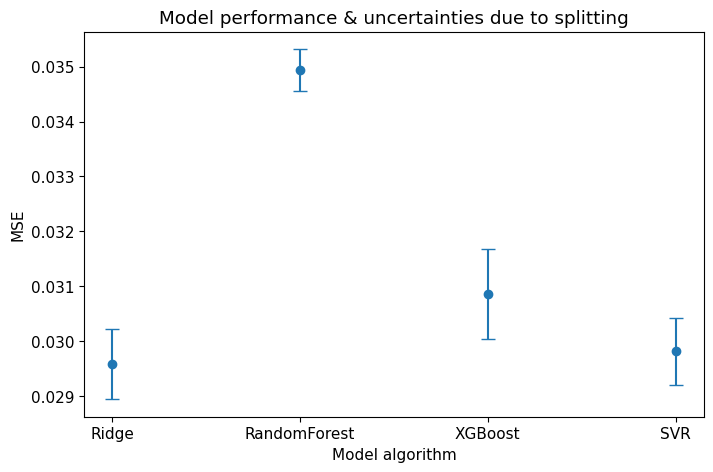

In [317]:
filtered_model_names = [name for name in model_names if (name != "LinearRegression" and name != "Lasso")]
filtered_means = [test_score_means[name] for name in filtered_model_names]
filtered_stds = [test_score_stds[name] for name in filtered_model_names]

# Plot the results
plt.figure(figsize=(8, 5))
plt.errorbar(filtered_model_names, filtered_means, yerr=filtered_stds, fmt='o', capsize=5)
plt.title("Model performance & uncertainties due to splitting")
plt.xlabel("Model algorithm")
plt.ylabel("MSE")
plt.show()

### **Updated Markdown for Report**

---

### **Methods**

#### **Splitting Strategy**
The dataset was split into **training (60%)**, **validation (20%)**, and **test (20%)** sets to evaluate model performance effectively. I used the `train_test_split` method from `scikit-learn` with three different random seeds to account for variability introduced by random splitting. This approach ensures robust evaluation metrics that are not overly dependent on a single split.

#### **Data Preprocessing**
- **Categorical Variables**: Processed using **OneHotEncoder** to convert them into numerical formats suitable for modeling.
- **Ordinal Variables**: Transformed using **OrdinalEncoder** to retain the ordinal nature of the data.
- **Missing Values**: 
  - **Categorical features** were imputed using the most frequent value.
  - **Numerical features** were imputed using **IterativeImputer** to preserve relationships between features.
- **Numerical Scaling**: All numerical features were scaled using **StandardScaler** to ensure consistent magnitude, which benefits models sensitive to feature scaling.

#### **Machine Learning Pipeline**
I implemented a pipeline to automate data preprocessing and modeling for the following algorithms:

1. **Linear Models**:
   - **LinearRegression**: Basic linear regression without regularization.
   - **Ridge**: Linear regression with L2 regularization.
   - **Lasso**: Linear regression with L1 regularization.

2. **Non-Linear Models**:
   - **RandomForestRegressor**: An ensemble-based tree model capable of capturing complex feature interactions.
   - **XGBoost**: Gradient boosting that handles non-linear relationships well.
   - **SVR (Support Vector Regression)**: A kernel-based approach for non-linear regression.

#### **Hyperparameter Tuning**
Hyperparameters for each model were tuned using a grid search with cross-validation on the training and validation sets. The following parameters were explored:
- **Ridge**: Regularization strength (`alpha`) was varied over `[0.01, 0.1, 1, 10, 100]`.
- **Lasso**: Regularization strength (`alpha`) was tuned over `[0.01, 0.1, 1, 10, 100]`.
- **RandomForest**: Maximum depth (`max_depth`) and maximum features (`max_features`) were explored.
- **XGBoost**: Learning rate, number of estimators, and regularization parameters (`reg_alpha` and `reg_lambda`) were tuned.
- **SVR**: Regularization parameter (`C`) and kernel coefficients (`gamma`) were tuned.

#### **Evaluation Metrics**
The **Mean Squared Error (MSE)** was selected as the primary evaluation metric because:
1. It emphasizes larger errors by squaring deviations, which is beneficial in regression tasks with outliers.
2. It provides a clear measure of the difference between predicted and actual values, making it interpretable for continuous outcomes.

To measure uncertainties:
1. **Splitting Variability**:
   - The dataset was split into train-validation-test sets using three different random states.
   - Metrics were averaged across splits to account for variability in data partitioning.
2. **Model Stochasticity**:
   - Models like Random Forest and XGBoost were trained multiple times with different random seeds, and their metrics were averaged.

---

### **Results**

#### **Baseline**
The baseline MSE was computed using the mean of the target variable as a constant prediction:
\
$\text{Baseline MSE} = \frac{1}{N} \sum_{i=1}^{N} (y_i - \bar{y})^2$
\
This provides a point of comparison for the model performances.

#### **Model Performance**
The table below summarizes the average performance across three random splits for each model:

| Model             | Best Hyperparameters                        | Mean Train MSE | Mean Validation MSE | Mean Test MSE | Notes              |
|--------------------|---------------------------------------------|----------------|----------------------|---------------|--------------------|
| LinearRegression  | Default                                      | 0.0114         |5.1556e+19)   | 3.0287e+20  | Unstable          |
| Ridge             | `{'alpha': 0.01}`                           | 0.0114         | 0.0121               | 0.0122         | Best performer     |
| Lasso             | `{'alpha': 0.01}`                           | 0.0364         | 0.0367               | 0.0370         | Underperformed     |
| RandomForest      | `{'max_depth': 30, 'max_features': 0.5}`    | 0.0096         | 0.0141               | 0.0142         | Overfitting risk   |
| XGBoost           | `{'learning_rate': 0.03, 'n_estimators': 2500, 'reg_alpha': 0.0, 'reg_lambda': 10.0}` | 0.0095         | 0.0123               | 0.0124         | Strong performer   |
| SVR               | `{'C': 10, 'gamma': 'auto'}`                | 0.0115         | 0.0126               | 0.0128         | Performs well      |

#### **Observations**
1. **LinearRegression** exhibited instability due to extreme values in predictions, likely caused by multicollinearity or insufficient regularization.
2. **Ridge** consistently outperformed other models, demonstrating the effectiveness of L2 regularization for this dataset.
3. **Lasso** underperformed, suggesting that most features contribute to the target variable and should not be eliminated.
4. Non-linear models like **RandomForest** and **XGBoost** performed well but showed signs of overfitting, particularly with deeper trees.
5. **SVR** delivered competitive results but required careful tuning of kernel parameters.

---

### **Next Steps**

1. **Feature Importance Analysis**:
   - Calculate global feature importance using:
     - **Permutation Importance**: To quantify the impact of each feature on the predictions.
     - **Feature Importance Scores** from Random Forest and XGBoost.
   - Implement **SHAP (SHapley Additive exPlanations)** to evaluate local and global feature importance.

2. **Address LinearRegression Instability**:
   - Investigate multicollinearity among features and apply techniques like **Variance Inflation Factor (VIF)** analysis.
   - Standardize the data further or introduce regularization.

3. **Refine Non-Linear Models**:
   - Random Forest:
     - Test lower `max_depth` values to mitigate overfitting.
   - XGBoost:
     - Fine-tune regularization parameters (`reg_alpha`, `reg_lambda`) to balance model complexity and generalization.

4. **Measure Model Uncertainties**:
   - Use **repeated k-fold cross-validation** (e.g., 5 folds, 3 repetitions) to further evaluate the impact of data splitting.
   - Train Random Forest and XGBoost multiple times with different seeds to analyze stochastic variations in predictions.

5. **Visualizations**:
   - Plot model performances across splits using box plots to visualize variability.
   - Create SHAP summary plots to explain individual model predictions.

6. **Comparison Against Baseline**:
   - Clearly quantify the improvements of each model over the baseline MSE.
   - Highlight models that perform significantly better than the baseline in terms of standard deviations.

---

This structure captures the current state of your work, highlights key findings, and lays out actionable next steps for refinement and interpretation. Let me know if you need help implementing any specific part!

In [268]:
baseline_prediction = np.mean(y)
baseline_mse = np.mean((y - baseline_prediction) ** 2)

baseline_prediction, baseline_mse

(0.48147529889465374, 0.07478040864995014)

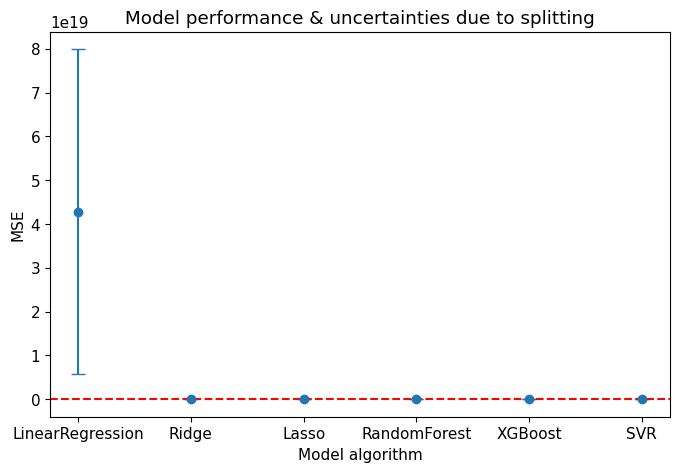

In [330]:
# Plot the results
model_names = list(test_scores.keys())
means = [test_score_means[name] for name in model_names]
stds = [test_score_stds[name] for name in model_names]

plt.figure(figsize=(8, 5))
plt.errorbar(model_names, means, yerr=stds, fmt='o', capsize=5)
plt.axhline(y=baseline_mse, color='r', linestyle='--', label="Baseline")

plt.title("Model performance & uncertainties due to splitting")
plt.xlabel("Model algorithm")
plt.ylabel("MSE")
plt.show()

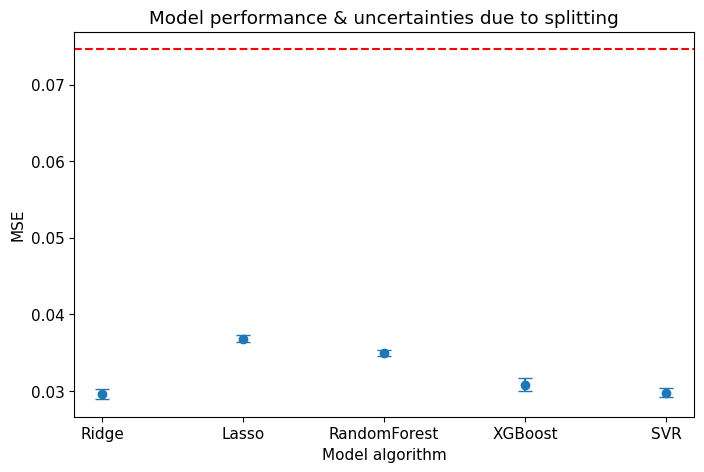

In [331]:
filtered_model_names = [name for name in model_names if name != "LinearRegression"]
filtered_means = [test_score_means[name] for name in filtered_model_names]
filtered_stds = [test_score_stds[name] for name in filtered_model_names]

# Plot the results
plt.figure(figsize=(8, 5))
plt.errorbar(filtered_model_names, filtered_means, yerr=filtered_stds, fmt='o', capsize=5)
plt.axhline(y=baseline_mse, color='r', linestyle='--', label="Baseline")

plt.title("Model performance & uncertainties due to splitting")
plt.xlabel("Model algorithm")
plt.ylabel("MSE")
plt.show()

In [271]:
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge

def ML_pipeline_kfold_ridge(X, y, random_state, n_folds):
    # Create a test set
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

    # Splitter for cross-validation
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=random_state)

    # Pipeline with Ridge regression
    pipe = make_pipeline(preprocessor, Ridge())

    # Parameter grid
    param_grid = {
        'ridge__alpha': [1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2],  # Regularization strength
    }

    # Prepare GridSearchCV
    grid = GridSearchCV(pipe, param_grid=param_grid, cv=kf, return_train_score=True, n_jobs=-1, verbose=True)

    # Perform k-fold CV on X_other
    grid.fit(X_other, y_other)

    # Return the grid search results and test set
    return grid, X_test, y_test

In [272]:
from sklearn.metrics import mean_squared_error
import pickle

model, X_test, y_test = ML_pipeline_kfold_ridge(X,y,42,4)

# Calculate MSE for the test set
y_test_pred = model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
print("Best cross-validation score (R^2):", model.best_score_)  # Negative MSE from GridSearchCV
print("Test set MSE:", test_mse)
print("Best parameters:", model.best_params_)

# Save the model and test MSE
file = open('data/results/grid_ridge.save', 'wb')
pickle.dump((model, X_test, y_test), file)
file.close()

Fitting 4 folds for each of 6 candidates, totalling 24 fits
Best cross-validation score (R^2): 0.605453282255892
Test set MSE: 0.029747214495538986
Best parameters: {'ridge__alpha': 1.0}


In [273]:
import numpy as np
from sklearn.metrics import mean_squared_error
import pickle

# Load the saved model and data
file = open('data/results/grid_ridge.save', 'rb')
model, X_test, y_test = pickle.load(file)
file.close()

np.random.seed(42)

ftr_names = X_test.columns

nr_runs = 10
scores = np.zeros([len(ftr_names), nr_runs])

# Baseline prediction using the mean of the target
baseline_prediction = np.mean(y_test)  # Use the test set mean
baseline_mse = np.mean((y_test - baseline_prediction) ** 2)

# Calculate the test set MSE
y_test_pred = model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
print('Test MSE =', test_mse)
print('Baseline MSE =', baseline_mse)

# Loop through the features for permutation importance using MSE
for i in range(len(ftr_names)):
    print('Shuffling feature:', str(ftr_names[i]))
    acc_scores = []
    for j in range(nr_runs):
        X_test_shuffled = X_test.copy()
        # Shuffle the selected feature
        X_test_shuffled[ftr_names[i]] = np.random.permutation(X_test[ftr_names[i]].values)
        # Predict and calculate MSE with the shuffled feature
        y_test_shuffled_pred = model.predict(X_test_shuffled)
        shuffled_mse = mean_squared_error(y_test, y_test_shuffled_pred)
        acc_scores.append(shuffled_mse)
    # Calculate mean and std deviation of shuffled MSEs
    print('   Shuffled test MSE:', np.around(np.mean(acc_scores), 3), '+/-', np.around(np.std(acc_scores), 3))
    scores[i] = acc_scores


Test MSE = 0.029747214495538986
Baseline MSE = 0.07460487324043191
Shuffling feature: Breed
   Shuffled test MSE: 0.108 +/- 0.002
Shuffling feature: Gender
   Shuffled test MSE: 0.034 +/- 0.0
Shuffling feature: SpayNeuter
   Shuffled test MSE: 0.03 +/- 0.0
Shuffling feature: Borough
   Shuffled test MSE: 0.031 +/- 0.0
Shuffling feature: Season
   Shuffled test MSE: 0.038 +/- 0.0
Shuffling feature: Age_Range
   Shuffled test MSE: 0.03 +/- 0.0


/var/folders/pw/j1b5757d4hg8vhmyx5h9rmjh0000gn/T/ipykernel_14520/3804670318.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(scores[sorted_indcs].T, labels=np.array(ftr_names)[sorted_indcs], vert=False)


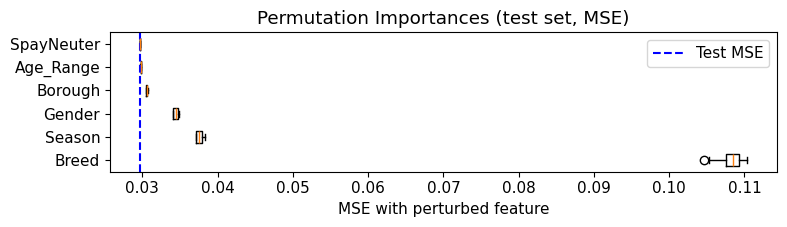

In [274]:
import matplotlib.pyplot as plt
import numpy as np

# Sort the features by the mean of the shuffled MSE scores (descending order)
sorted_indcs = np.argsort(np.mean(scores, axis=1))[::-1]

# Plot settings
plt.rcParams.update({'font.size': 11})
plt.figure(figsize=(8, len(ftr_names) * 0.4))  # Adjust height dynamically for readability
plt.boxplot(scores[sorted_indcs].T, labels=np.array(ftr_names)[sorted_indcs], vert=False)

# Add a vertical line for the test set MSE
plt.axvline(test_mse, color='blue', linestyle='--', label='Test MSE')

# Add labels and title
plt.title("Permutation Importances (test set, MSE)")
plt.xlabel('MSE with perturbed feature')
plt.legend()
plt.tight_layout()
plt.show()


In [288]:
def ML_pipeline_kfold_SVR(X, y, random_state, n_folds):
    # Create a test set
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

    # Splitter for cross-validation
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=random_state)

    # Pipeline with Ridge regression
    pipe = make_pipeline(preprocessor, SVR())

    # Parameter grid
    param_grid = {
        'svr__C': [1e1, 1e2, 1e3, 1e4],
        'svr__gamma': [1e-4, 1e-3, 1e-2, 1e-1, 1e0],
    }

    # Prepare GridSearchCV
    grid = GridSearchCV(pipe, param_grid=param_grid, cv=kf, return_train_score=True, n_jobs=-1, verbose=True)

    # Perform k-fold CV on X_other
    grid.fit(X_other, y_other)

    # Return the grid search results and test set
    return grid, X_test, y_test

In [289]:
from xgboost import XGBRegressor

model, X_test, y_test = ML_pipeline_kfold_SVR(X,y,42,4)

# Calculate MSE for the test set
y_test_pred = model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
print("Best cross-validation score (R^2):", model.best_score_)  # Negative MSE from GridSearchCV
print("Test set MSE:", test_mse)
print("Best parameters:", model.best_params_)

# Save the model and test MSE
file = open('data/results/grid_SVR.save', 'wb')
pickle.dump((model, X_test, y_test), file)
file.close()

Fitting 4 folds for each of 20 candidates, totalling 80 fits
Best cross-validation score (R^2): 0.6034652349965351
Test set MSE: 0.029852879075052387
Best parameters: {'svr__C': 1000.0, 'svr__gamma': 0.0001}


In [290]:
import numpy as np
from sklearn.metrics import mean_squared_error
import pickle

# Load the saved model and data
file = open('data/results/grid_SVR.save', 'rb')
model, X_test, y_test = pickle.load(file)
file.close()

np.random.seed(42)

ftr_names = X_test.columns

nr_runs = 10
scores = np.zeros([len(ftr_names), nr_runs])

# Baseline prediction using the mean of the target
baseline_prediction = np.mean(y_test)  # Use the test set mean
baseline_mse = np.mean((y_test - baseline_prediction) ** 2)

# Calculate the test set MSE
y_test_pred = model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
print('Test MSE =', test_mse)
print('Baseline MSE =', baseline_mse)

# Loop through the features for permutation importance using MSE
for i in range(len(ftr_names)):
    print('Shuffling feature:', str(ftr_names[i]))
    acc_scores = []
    for j in range(nr_runs):
        X_test_shuffled = X_test.copy()
        # Shuffle the selected feature
        X_test_shuffled[ftr_names[i]] = np.random.permutation(X_test[ftr_names[i]].values)
        # Predict and calculate MSE with the shuffled feature
        y_test_shuffled_pred = model.predict(X_test_shuffled)
        shuffled_mse = mean_squared_error(y_test, y_test_shuffled_pred)
        acc_scores.append(shuffled_mse)
    # Calculate mean and std deviation of shuffled MSEs
    print('   Shuffled test MSE:', np.around(np.mean(acc_scores), 3), '+/-', np.around(np.std(acc_scores), 3))
    scores[i] = acc_scores


Test MSE = 0.029852879075052387
Baseline MSE = 0.07460487324043191
Shuffling feature: Breed
   Shuffled test MSE: 0.11 +/- 0.002
Shuffling feature: Gender
   Shuffled test MSE: 0.035 +/- 0.0
Shuffling feature: SpayNeuter
   Shuffled test MSE: 0.03 +/- 0.0
Shuffling feature: Borough
   Shuffled test MSE: 0.031 +/- 0.0
Shuffling feature: Season
   Shuffled test MSE: 0.038 +/- 0.0
Shuffling feature: Age_Range
   Shuffled test MSE: 0.03 +/- 0.0


/var/folders/pw/j1b5757d4hg8vhmyx5h9rmjh0000gn/T/ipykernel_14520/3916736048.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(scores[sorted_indcs].T, labels=np.array(ftr_names)[sorted_indcs], vert=False)


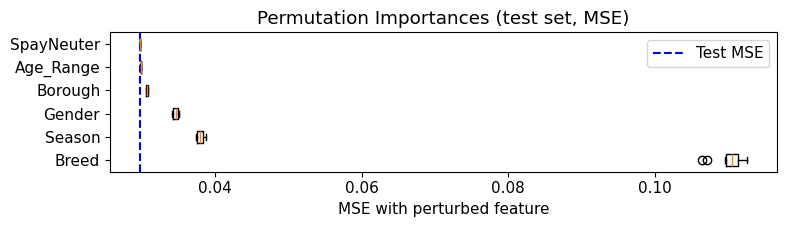

In [291]:
import matplotlib.pyplot as plt
import numpy as np

# Sort the features by the mean of the shuffled MSE scores (descending order)
sorted_indcs = np.argsort(np.mean(scores, axis=1))[::-1]

# Plot settings
plt.rcParams.update({'font.size': 11})
plt.figure(figsize=(8, len(ftr_names) * 0.4))  # Adjust height dynamically for readability
plt.boxplot(scores[sorted_indcs].T, labels=np.array(ftr_names)[sorted_indcs], vert=False)

# Add a vertical line for the test set MSE
plt.axvline(test_mse, color='blue', linestyle='--', label='Test MSE')

# Add labels and title
plt.title("Permutation Importances (test set, MSE)")
plt.xlabel('MSE with perturbed feature')
plt.legend()
plt.tight_layout()
plt.show()

In [292]:
def ML_pipeline_kfold_SVR(X, y, random_state, n_folds):
    # Create a test set
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

    # Splitter for cross-validation
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=random_state)

    # Pipeline with Ridge regression
    pipe = make_pipeline(preprocessor, SVR())

    # Parameter grid
    param_grid = {
        'svr__C': [1e4, 1e5, 1e6],
        'svr__gamma': [1e-6, 1e-5, 1e-4],
    }

    # Prepare GridSearchCV
    grid = GridSearchCV(pipe, param_grid=param_grid, cv=kf, return_train_score=True, n_jobs=-1, verbose=True)

    # Perform k-fold CV on X_other
    grid.fit(X_other, y_other)

    # Return the grid search results and test set
    return grid, X_test, y_test

In [293]:
from xgboost import XGBRegressor

model, X_test, y_test = ML_pipeline_kfold_SVR(X,y,42,4)

# Calculate MSE for the test set
y_test_pred = model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
print("Best cross-validation score (R^2):", model.best_score_)  # Negative MSE from GridSearchCV
print("Test set MSE:", test_mse)
print("Best parameters:", model.best_params_)

# Save the model and test MSE
file = open('data/results/grid_SVR.save', 'wb')
pickle.dump((model, X_test, y_test), file)
file.close()

Fitting 4 folds for each of 9 candidates, totalling 36 fits
Best cross-validation score (R^2): 0.6019811688729594
Test set MSE: 0.029992660281554576
Best parameters: {'svr__C': 10000.0, 'svr__gamma': 0.0001}


In [294]:
import numpy as np
from sklearn.metrics import mean_squared_error
import pickle

# Load the saved model and data
file = open('data/results/grid_SVR.save', 'rb')
model, X_test, y_test = pickle.load(file)
file.close()

np.random.seed(42)

ftr_names = X_test.columns

nr_runs = 10
scores = np.zeros([len(ftr_names), nr_runs])

# Baseline prediction using the mean of the target
baseline_prediction = np.mean(y_test)  # Use the test set mean
baseline_mse = np.mean((y_test - baseline_prediction) ** 2)

# Calculate the test set MSE
y_test_pred = model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
print('Test MSE =', test_mse)
print('Baseline MSE =', baseline_mse)

# Loop through the features for permutation importance using MSE
for i in range(len(ftr_names)):
    print('Shuffling feature:', str(ftr_names[i]))
    acc_scores = []
    for j in range(nr_runs):
        X_test_shuffled = X_test.copy()
        # Shuffle the selected feature
        X_test_shuffled[ftr_names[i]] = np.random.permutation(X_test[ftr_names[i]].values)
        # Predict and calculate MSE with the shuffled feature
        y_test_shuffled_pred = model.predict(X_test_shuffled)
        shuffled_mse = mean_squared_error(y_test, y_test_shuffled_pred)
        acc_scores.append(shuffled_mse)
    # Calculate mean and std deviation of shuffled MSEs
    print('   Shuffled test MSE:', np.around(np.mean(acc_scores), 3), '+/-', np.around(np.std(acc_scores), 3))
    scores[i] = acc_scores


Test MSE = 0.029992660281554576
Baseline MSE = 0.07460487324043191
Shuffling feature: Breed
   Shuffled test MSE: 0.111 +/- 0.002
Shuffling feature: Gender
   Shuffled test MSE: 0.035 +/- 0.0
Shuffling feature: SpayNeuter
   Shuffled test MSE: 0.03 +/- 0.0
Shuffling feature: Borough
   Shuffled test MSE: 0.031 +/- 0.0
Shuffling feature: Season
   Shuffled test MSE: 0.038 +/- 0.0
Shuffling feature: Age_Range
   Shuffled test MSE: 0.03 +/- 0.0


/var/folders/pw/j1b5757d4hg8vhmyx5h9rmjh0000gn/T/ipykernel_14520/2886995980.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(scores[sorted_indcs].T, labels=np.array(ftr_names)[sorted_indcs], vert=False)


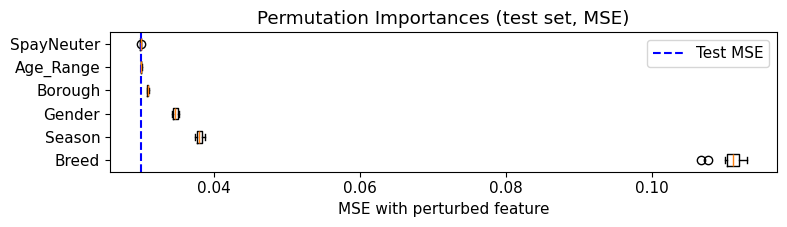

In [295]:
# Sort the features by the mean of the shuffled MSE scores (descending order)
sorted_indcs = np.argsort(np.mean(scores, axis=1))[::-1]

# Plot settings
plt.rcParams.update({'font.size': 11})
plt.figure(figsize=(8, len(ftr_names) * 0.4))  # Adjust height dynamically for readability
plt.boxplot(scores[sorted_indcs].T, labels=np.array(ftr_names)[sorted_indcs], vert=False)

# Add a vertical line for the test set MSE
plt.axvline(test_mse, color='blue', linestyle='--', label='Test MSE')

# Add labels and title
plt.title("Permutation Importances (test set, MSE)")
plt.xlabel('MSE with perturbed feature')
plt.legend()
plt.tight_layout()
plt.show()

Fitting 4 folds for each of 6 candidates, totalling 24 fits


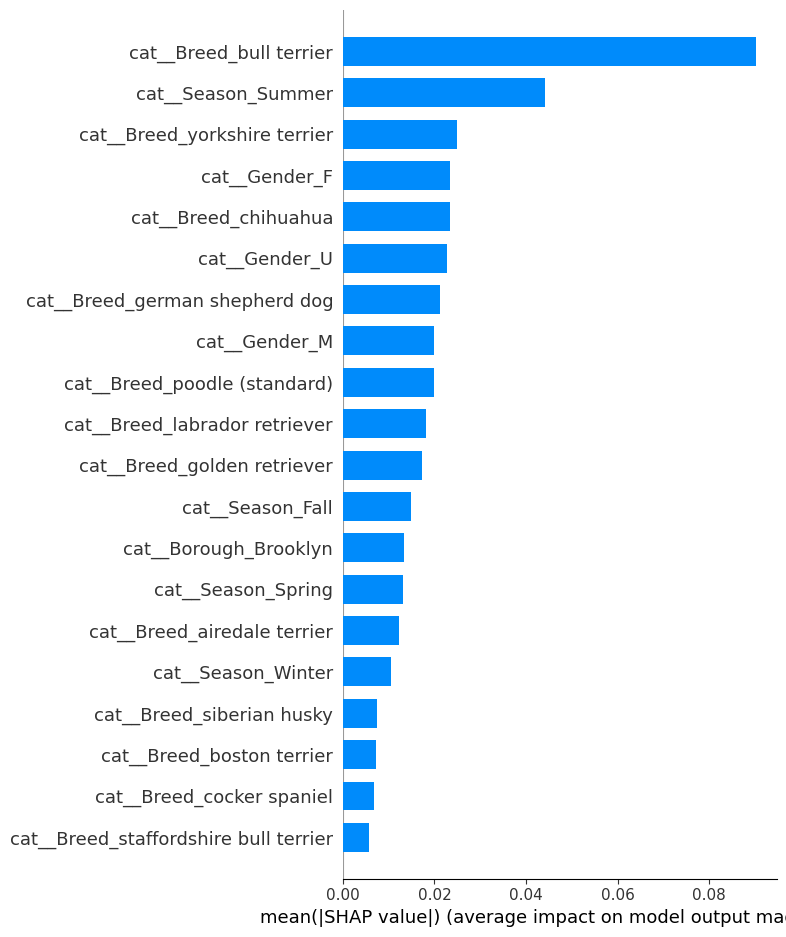

In [300]:
import shap
import matplotlib.pyplot as plt

def generate_shap_explanation(grid, X_test, index):
    # Get the best estimator from GridSearchCV
    best_estimator = grid.best_estimator_

    # Use the pipeline to preprocess the test data
    X_test_prep = best_estimator[:-1].transform(X_test)  # Apply all pipeline steps except the final Ridge model

    # Initialize SHAP explainer for linear models
    explainer = shap.LinearExplainer(best_estimator.named_steps['ridge'], X_test_prep)

    # Calculate SHAP values
    shap_values = explainer.shap_values(X_test_prep)

    # Visualize the SHAP values
    shap.summary_plot(shap_values, X_test_prep, plot_type="bar", feature_names=grid.best_estimator_[:-1].get_feature_names_out())
    
    # Example force plot for a single instance
    # index = index  # Choose an instance to explain
    shap.force_plot(
        explainer.expected_value, 
        shap_values[index, :], 
        features=X_test_prep[index, :], 
        feature_names=grid.best_estimator_[:-1].get_feature_names_out()
    )

# Example usage
grid, X_test, y_test = ML_pipeline_kfold_ridge(X, y, random_state=42, n_folds=4)
generate_shap_explanation(grid, X_test, )

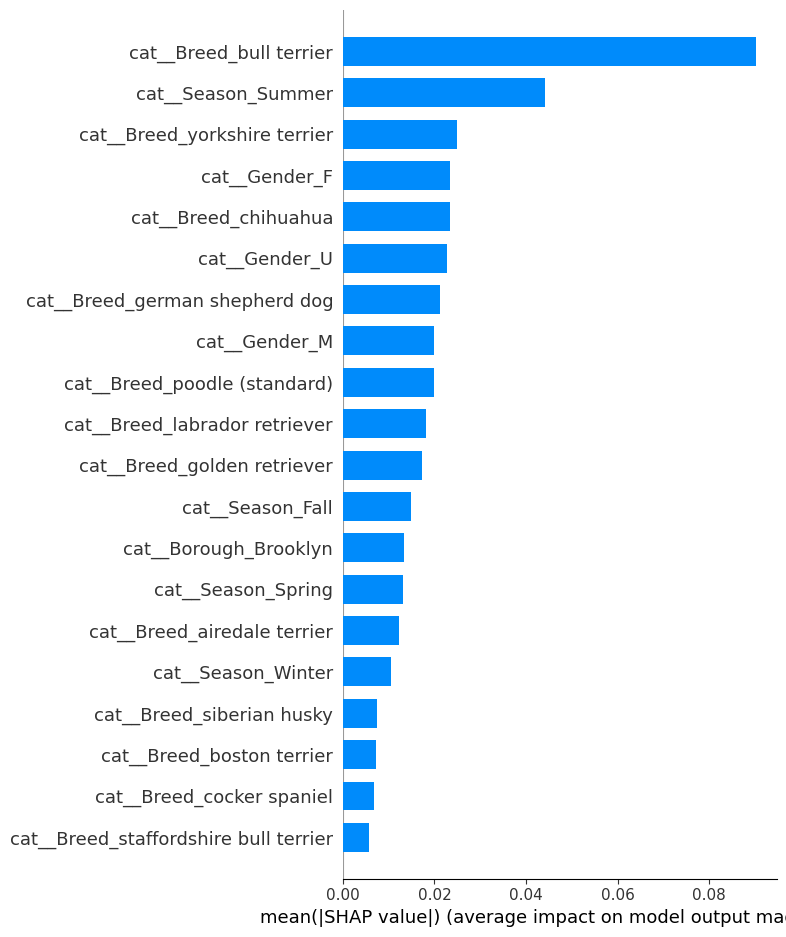

In [302]:
generate_shap_explanation(grid, X_test, 60)

In [313]:
import shap
shap.initjs() # required for visualizations later on

grid, X_test, y_test = ML_pipeline_kfold_ridge(X, y, random_state=42, n_folds=4)

X_test_transformed = grid.best_estimator_[0].transform(X_test)

masker = shap.maskers.Independent(X_test_transformed)  # Use Independent masker
# create the explainer object with the random forest model
explainer = shap.LinearExplainer(grid.best_estimator_[1], masker=masker)

# calculate shap values on the first 1000 points in the test
shap_values = explainer.shap_values(X_test_transformed[:1000])
print(np.shape(shap_values))

Fitting 4 folds for each of 6 candidates, totalling 24 fits
(1000, 181)


In [314]:
index = 1  # the index of the point to explain
print(explainer.expected_value)  # No indexing needed; it's a scalar

# Explain the prediction for the selected point
shap.force_plot(
    explainer.expected_value,  # Single expected value
    shap_values[index, :],     # SHAP values for the selected point
    features=X_test_transformed[index, :],  # Features for the selected point
    feature_names=grid.best_estimator_[:-1].get_feature_names_out()
)

0.5095940276115719


In [325]:
index = 80  # the index of the point to explain
print(explainer.expected_value)  # No indexing needed; it's a scalar

# Explain the prediction for the selected point
shap.force_plot(
    explainer.expected_value,  # Single expected value
    shap_values[index, :],     # SHAP values for the selected point
    features=X_test_transformed[index, :],  # Features for the selected point
    feature_names=grid.best_estimator_[:-1].get_feature_names_out()
)

0.5095940276115719


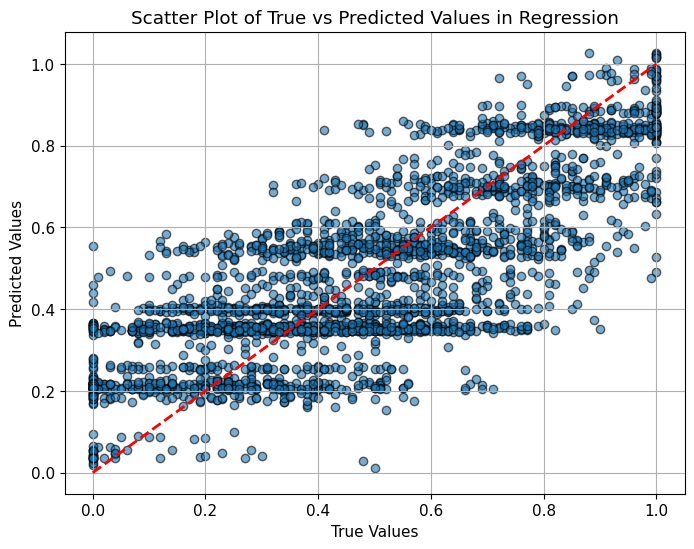

In [316]:
import matplotlib.pyplot as plt

# Get predictions on the test set
y_pred = grid.predict(X_test)

# Scatter plot of true vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Scatter Plot of True vs Predicted Values in Regression")
plt.grid(True)
plt.show()

In [319]:
import shap
shap.initjs() # required for visualizations later on
# create the explainer object with the random forest model
masker = shap.maskers.Independent(X_test_transformed)  # Use Independent masker
# create the explainer object with the random forest model
explainer = shap.LinearExplainer(grid.best_estimator_[1], masker=masker)
# transform the test set 
X_test_transformed = grid.best_estimator_[0].transform(X_test)

print(np.shape(X_test_transformed))
# calculate shap values on the first 1000 points in the test
shap_values = explainer.shap_values(X_test_transformed[:1000])
print(np.shape(shap_values))

(2660, 181)
(1000, 181)


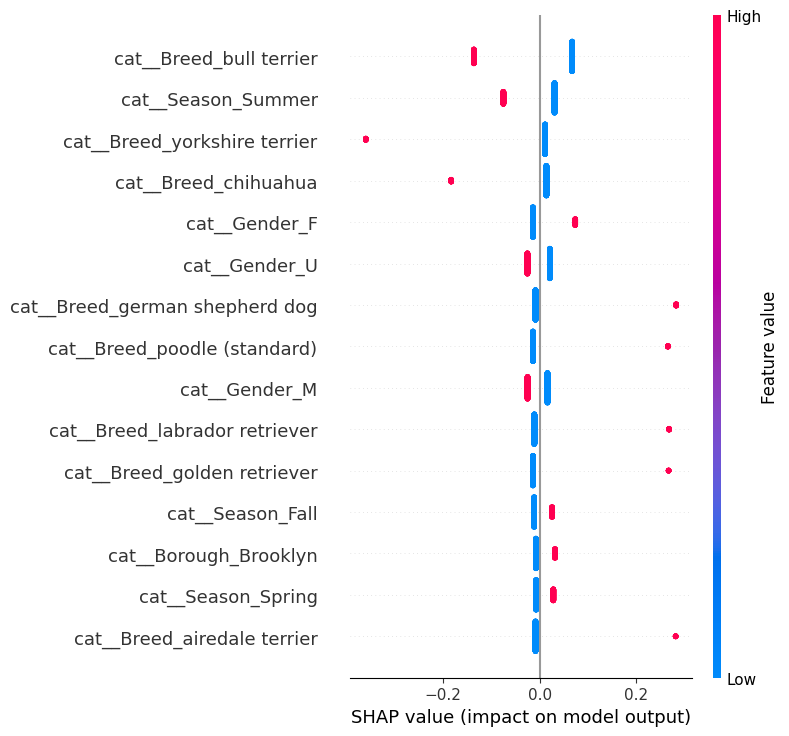

In [321]:
shap.summary_plot(shap_values, X_test_transformed[:1000], feature_names=grid.best_estimator_[:-1].get_feature_names_out()
, max_display=15)

In [322]:
shap_values

array([[-0.        , -0.0087096 ,  0.        , ..., -0.00055935,
        -0.00055935,  0.0007211 ],
       [-0.        , -0.0087096 ,  0.        , ..., -0.00055935,
        -0.00055935,  0.0007211 ],
       [-0.        , -0.0087096 ,  0.        , ..., -0.00055935,
        -0.00055935, -0.00051155],
       ...,
       [-0.        , -0.0087096 ,  0.        , ...,  0.00113565,
         0.00113565, -0.00051155],
       [-0.        , -0.0087096 ,  0.        , ..., -0.00055935,
        -0.00055935,  0.0007211 ],
       [-0.        , -0.0087096 ,  0.        , ...,  0.00113565,
         0.00113565, -0.00112787]])